## Imports

In [1]:
from crabnet.crabnet_ import get_data
from crabnet.data.materials_data import elasticity
from crabnet.crabnet_ import CrabNet

/workspaces/mat2vec_codespace/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
train_df, val_df = get_data(elasticity, "train.csv", dummy=True)

In [3]:
#今回取得したこのテストデータの内容を見る
display(train_df)

,formula,index,target
55,AcOF,"(4945,)",108.0
88,Ag3Hg,"(9906,)",75.0
26,AcAg2Sn,"(1581,)",61.0
42,AcH3,"(5473,)",68.0
69,Ag2BiO3,"(4664,)",100.0
...,...,...,...
60,AcTe3,"(1705,)",48.0
71,Ag2F,"(306,)",74.0
14,Ac2SiAu,"(3552,)",62.0
92,Ag3Pd,"(5953,)",99.0


In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   formula  80 non-null     object 
 1   index    80 non-null     object 
 2   target   80 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.5+ KB
None


## CrabNet


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 64/64 [00:00<00:00, 64188.30formulae/s]


loading data with up to 4 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 16/16 [00:00<00:00, 38679.46formulae/s]

loading data with up to 4 elements in the formula
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler


Epoch: 0/40 --- train mae: 20.1 val mae: 23.7


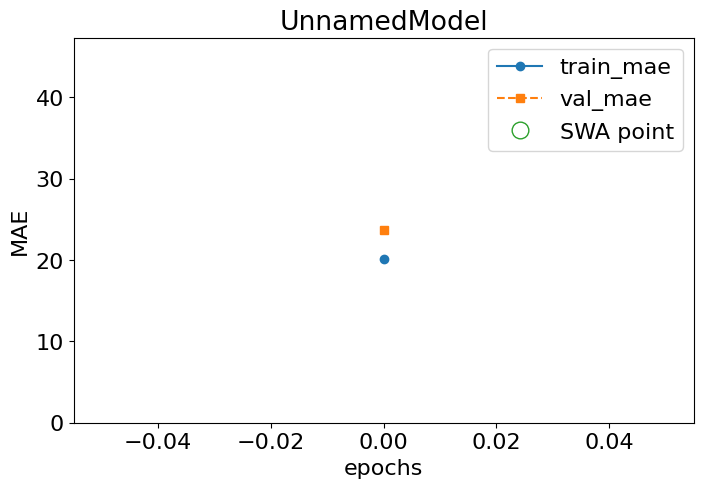

Epoch: 19/40 --- train mae: 14.8 val mae: 22.1


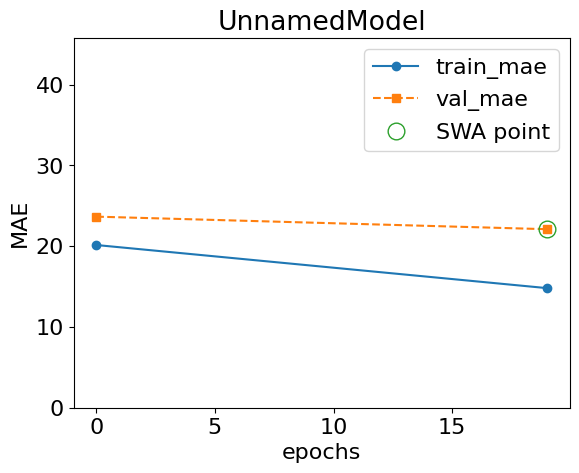

Epoch: 39/40 --- train mae: 13.8 val mae: 21.2


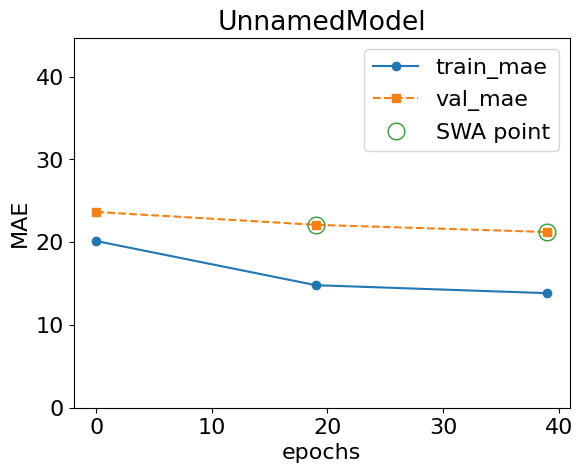

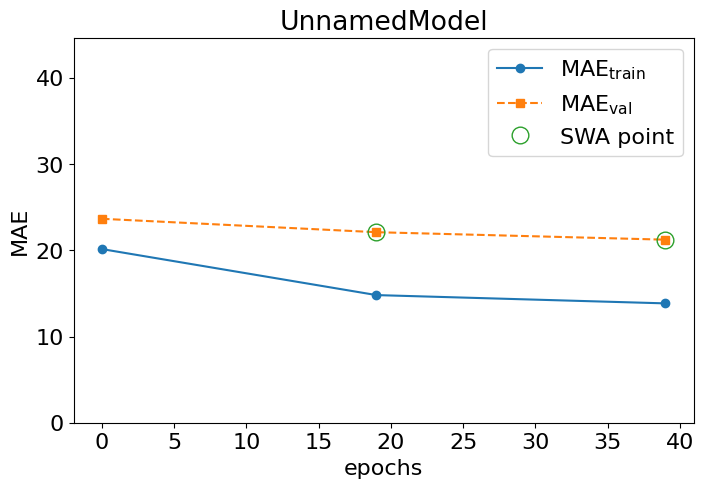

Saving network (UnnamedModel) to models/trained_models/UnnamedModel.pth


Generating EDM: 100%|██████████| 20/20 [00:00<00:00, 45003.26formulae/s]

loading data with up to 4 elements in the formula


In [5]:
%matplotlib inline
cb = CrabNet(mat_prop="elasticity", epochs=40)
cb.fit(train_df)
val_pred, val_sigma = cb.predict(val_df, return_uncertainty=True)

In [3]:
from os.path import join
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from crabnet.utils.data import get_data
from crabnet.crabnet_ import CrabNet
import vickers_hardness.data as vh_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
)
from vickers_hardness.utils.plotting import parity_with_err
from vickers_hardness.vickers_hardness_ import VickersHardness

In [4]:
X = get_data(vh_data, "hv_des.csv", groupby=False, split=False).rename(
    columns={"composition": "formula"}
)
prediction = get_data(vh_data, "hv_comp_load.csv", groupby=False, split=False)

In [5]:
display(X)

,formula,load,avg_ Atomic_Number,avg_ Atomic_Weight,avg_Period,avg_group,avg_families,avg_Mendeleev Number,avg_Atomic Radus,avg_ Covalent_Radius,...,min_Melting point (K),min_Boiling Point (K),min_Density (g/mL),min_specific heat (J/g K),min_heat of fusion (kJ/mol),min_heat of vaporization (kJ/mol),min_thermal conductivity (W/(m K)),min_heat atomization\n(kJ/mol),min_Cohesive energy,min_electron affinity (kJ/mol)
0,Ag0.05Gd0.048Pd0.902,0.49,46.914000,108.932250,5.048000,9.714000,3.952000,60.470000,1.429200,1.298840,...,1235.15,2485.15,7.90000,0.230,10.05000,250.5800,10.60000,284.0,2.95,13.2200
1,Ag0.05Y0.048Pd0.902,0.49,45.714000,105.651731,5.000000,9.714000,3.952000,59.750000,1.429200,1.299320,...,1235.15,2485.15,4.47000,0.235,11.30000,250.5800,17.20000,284.0,2.95,29.6000
2,Ag0.25Pb0.5Sb0.25Te,2.94,58.750000,144.303525,5.250000,14.750000,5.500000,84.000000,1.531250,1.390000,...,600.65,1262.95,6.24000,0.130,4.79900,52.5500,2.35000,196.0,2.03,34.4204
3,Al1.5Si1.5N2.5O1.5,0.98,10.000000,20.230930,2.428571,14.571429,6.357143,80.285714,0.864286,0.915000,...,54.75,77.35,0.00125,0.710,0.22259,2.7928,0.02598,249.0,2.62,-0.0700
4,Al1.67B22,2.00,5.564428,11.951887,2.070553,13.000000,5.929447,72.070553,0.878221,0.845399,...,933.15,2740.15,2.34000,0.900,10.79000,293.4000,27.00000,326.0,3.39,26.9890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,ZrV2,0.98,28.666667,64.369000,4.333333,4.666667,4.000000,45.333333,1.416667,1.296667,...,2125.15,3653.15,6.11000,0.270,16.90000,0.4520,22.70000,514.0,5.31,41.8100
1058,ZrW2,0.98,62.666667,152.968000,5.666667,5.333333,4.000000,48.666667,1.416667,1.350000,...,2125.15,4650.15,6.51000,0.130,16.90000,58.2000,22.70000,609.0,6.25,41.8100
1059,OsB2,0.25,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.9890
1060,OsB2,0.49,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.9890


In [8]:
display(prediction)
prediction.info()

,composition,hardness,load
0,Ag0.05Gd0.048Pd0.902,1.810,0.49
1,Ag0.05Y0.048Pd0.902,1.640,0.49
2,Ag0.25Pb0.5Sb0.25Te,0.578,2.94
3,Al1.5Si1.5N2.5O1.5,15.030,0.98
4,Al1.67B22,23.800,2.00
...,...,...,...
1057,ZrV2,3.600,0.98
1058,ZrW2,11.100,0.98
1059,OsB2,34.800,0.25
1060,OsB2,27.000,0.49


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   composition  1062 non-null   object 
 1   hardness     1062 non-null   float64
 2   load         1062 non-null   float64
dtypes: float64(2), object(1)
memory usage: 25.0+ KB


In [9]:
#下記はCrabnetのExampleのコピーである
#これを説明していく
#vickersについては科学データのライブラリ
#今回調べているcrabnetと同様に組成式から硬度をXGboostなどを用いて評価することのできるライブラリであるらしい


"""Compare CrabNet `extend_features` with XGBoost for hardness dataset.

Dependency: `pip install vickers_hardness`, but then might run into issue with shapely.
See fix here: https://github.com/uncertainty-toolbox/uncertainty-toolbox/issues/59

"""


dummy = False
hyperopt = False
split_by_groups = True
remove_load = False

# %% directories
figure_dir = join("figures", "extend_features")#結果を保存する用ディレクトリの作成？
result_dir = join("results", "extend_features")#このjoinメソッドはディレクトリ作成用のメソッド

if remove_load:
    figure_dir = join(figure_dir, "without_load")
    result_dir = join(result_dir, "without_load")

crabnet_figures = join(figure_dir, "crabnet")
crabnet_results = join(result_dir, "crabnet")

xgboost_figures = join(figure_dir, "xgboost")
xgboost_results = join(result_dir, "xgboost")

for path in [crabnet_figures, crabnet_results, xgboost_figures, xgboost_results]:#リストの内部に書かれているものに対して操作
    Path(path).mkdir(parents=True, exist_ok=True)#リスト内の候補に応じて新たなディレクトリの作成

# %% load dataset
X = get_data(vh_data, "hv_des.csv", groupby=False, split=False).rename(
    columns={"composition": "formula"}
)
prediction = get_data(vh_data, "hv_comp_load.csv", groupby=False, split=False)
y = prediction["hardness"]
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

#上記のプログラムでvickersのライブラリからデータを取得して引っ張ってきている

if dummy:
    X = X.head(50)
    y = y.head(50)

if remove_load:
    X["load"] = np.zeros(X.shape[0])  # could try np.random.rand

# %% K-fold cross-validation
if split_by_groups:
    ss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    cv = GroupKFold()
    cvtype = "gcv"
else:
    ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    cv = KFold(shuffle=True, random_state=100)  # ignores groups
    cvtype = "cv"

if split_by_groups:
    groups = X["formula"]
else:
    groups = None

trainval_idx, test_idx = list(ss.split(X, y, groups=groups))[0]
X_test, y_test = X.iloc[test_idx, :], y[test_idx]
X, y = X.iloc[trainval_idx, :], y.iloc[trainval_idx]

if split_by_groups:
    subgroups = X["formula"]
else:
    subgroups = None

crabnet_dfs = []#ここでdfのリストを作成　ここで作成したdfのリストはあとで一括でconcatでくっつけることが出来るっぽい
xgb_dfs = []

In [10]:
for train_index, test_index in cv.split(X, y, subgroups):#上記のcvをしたそれぞれのデータセットのペアごとに処理を実行
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    train_df = pd.DataFrame(
        {"formula": X_train["formula"], "load": X_train["load"], "target": y_train}
    )
    val_df = pd.DataFrame(
        {"formula": X_val["formula"], "load": X_val["load"], "target": y_val}
    )
    
    display(train_df)
    display(val_df)
    
    cb = CrabNet(#ここでCrabNetのモデルを作成 学習時に表示されている学習曲線の表示や学習時のbatch数などについてはここで設定を行う
                 #今回のモデルだとデフォルトのbatch数は128
        extend_features=["load"],
        verbose=True,
        learningcurve=True,
        losscurve = True,
        random_state = 42,
    )
    cb.fit(train_df)#モデル訓練　内容は不明だがもしかして完成したモデルの出力も行われている可能性がある
    
    y_pred, y_std, y_true,  = cb.predict(test_df = val_df, return_uncertainty = True, return_true = True)#原文ママではエラー　原因は出力が4つも出てこないということ、実際オプションでy_trueおよびy_stdを追加することは可能
    #ただし、何もオプションを入れていない時点では、予測された結果値のみが出力される
    #得られるstdは予測された値の標準偏差を示している
    crabnet_dfs.append(#答えのファイルの作成
        pd.DataFrame(
            {
                "actual_hardness": y_true,
                "predicted_hardness": y_pred,
                "y_std": y_std,
                "load": val_df["load"],
                "formula": val_df["formula"],
            }
        )
    )

    vickers = VickersHardness(hyperopt=hyperopt)#Crabnetとやっていることは同じ
    vickers.fit(X_train, y_train)
    y_pred, y_std = vickers.predict(X_val, y_val, return_uncertainty=True)
    xgb_dfs.append(
        pd.DataFrame(
            {
                "actual_hardness": val_df["target"],
                "predicted_hardness": y_pred,
                "y_std": y_std,
                "load": val_df["load"],
                "formula": val_df["formula"],
            }
        )
    )

crabnet_df = pd.concat(crabnet_dfs)#dfの作成
xgb_df = pd.concat(xgb_dfs)

parity_with_err(#不明　何かのエラー計算関数？
    crabnet_df,
    error_y="y_std",
    figfolder=crabnet_figures,
    fname=f"parity_stderr_{cvtype}",
)
parity_with_err(
    xgb_df,
    error_y="y_std",
    figfolder=xgboost_figures,
    fname=f"parity_stderr_{cvtype}",
)

names: List[str] = ["crabnet", "xgboost"]
for name in names:
    if name == "crabnet":
        tmp_df = crabnet_df
    elif name == "xgboost":
        tmp_df = xgb_df
    else:
        raise NotImplementedError(f"{name} not implemented")

    y_true, y_pred = [tmp_df["actual_hardness"], tmp_df["predicted_hardness"]]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name} MAE: {mae:.5f}")
    print(f"{name} RMSE: {rmse:.5f}")
    tmp_df.sort_index().to_csv(join(result_dir, name, f"{cvtype}-results.csv"))


# %% results
## with applied load
# crabnet MAE: 3.06177
# crabnet RMSE: 5.12390
# xgboost MAE: 2.34908
# xgboost RMSE: 3.81564

## without applied load
# crabnet MAE: 4.42722
# crabnet RMSE: 6.24093
# xgboost MAE: 3.96865
# xgboost RMSE: 5.22576

#上記の結果からみてわかるのはxgboostのほうが成績がいいということだが、
# そもそもこのxgboostのモデルのほうはビッカーズ硬度を予測することに特化しているモデルであり、
# そのモデルに全く調整を行わずに肉薄した成績が出せているということは特筆すべき事項であると考える。

,formula,load,target
1,Ag0.05Y0.048Pd0.902,0.49,1.640
4,Al1.67B22,2.00,23.800
5,Al3BC3,0.25,20.700
6,Al3BC3,0.49,18.200
7,Al3BC3,10.00,11.100
...,...,...,...
1053,ZrMoAl,0.98,6.523
1055,ZrO2,0.98,13.000
1059,OsB2,0.25,34.800
1060,OsB2,0.49,27.000


,formula,load,target
0,Ag0.05Gd0.048Pd0.902,0.49,1.810000
3,Al1.5Si1.5N2.5O1.5,0.98,15.030000
17,AuSn,0.49,1.420000
22,B13N2,0.49,44.384000
23,B13N2,0.98,42.019435
...,...,...,...
1024,Zr0.8Mo2Ge0.2,0.98,8.947000
1035,Zr5Ge3,0.98,11.700000
1051,ZrMn2,0.98,7.860000
1056,ZrRh3,0.98,6.370000



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 620/620 [00:00<00:00, 94353.20formulae/s]


loading data with up to 5 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 156/156 [00:00<00:00, 90499.51formulae/s]

loading data with up to 5 elements in the formula
stepping every 50 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


KeyboardInterrupt: 

In [17]:
print(xgb_dfs)

[      actual_hardness  predicted_hardness     y_std  load  \
0            1.810000            2.646756  0.336696  0.49   
3           15.030000           27.220158  1.886818  0.98   
17           1.420000            1.233395  1.052001  0.49   
22          44.384000           54.886784  2.820579  0.49   
23          42.019435           50.413273  2.399951  0.98   
...               ...                 ...       ...   ...   
1024         8.947000            9.643683  1.603913  0.98   
1035        11.700000            8.873702  0.397060  0.98   
1051         7.860000            6.339836  0.387407  0.98   
1056         6.370000            3.989892  0.765842  0.98   
1057         3.600000            2.124737  0.427470  0.98   

                   formula  
0     Ag0.05Gd0.048Pd0.902  
3       Al1.5Si1.5N2.5O1.5  
17                    AuSn  
22                   B13N2  
23                   B13N2  
...                    ...  
1024         Zr0.8Mo2Ge0.2  
1035                Zr5Ge3  
1051 

In [6]:
y_pred, y_std, y_true = cb.predict(test_df = val_df, return_uncertainty = True, return_true = True)#原文ママではエラー　原因は出力が4つも出てこないということ、実際オプションでy_trueおよびy_stdを追加することは可能


Generating EDM: 100%|██████████| 195/195 [00:00<00:00, 131578.07formulae/s]


loading data with up to 5 elements in the formula


In [7]:
display(val_df)


,formula,load,target,count
0,Ag0.05Gd0.048Pd0.902,0.49,1.810000,3
3,Al1.5Si1.5N2.5O1.5,0.98,15.030000,4
17,AuSn,0.49,1.420000,2
22,B13N2,0.49,44.384000,2
23,B13N2,0.98,42.019435,2
...,...,...,...,...
1024,Zr0.8Mo2Ge0.2,0.98,8.947000,3
1035,Zr5Ge3,0.98,11.700000,2
1051,ZrMn2,0.98,7.860000,2
1056,ZrRh3,0.98,6.370000,2


In [12]:
print(y_pred)

[ 8.02202034 10.81468582  1.5459137  32.4542923  32.4542923  32.4542923
 32.4542923  36.22018814  6.14881516 29.02604485 29.02604485 29.02604485
  1.3875885   3.24492455 11.0726738  20.14719009 18.02102661  9.97533798
 35.94237518 13.14058208  4.17434311 30.06364059  2.43967819 30.73415375
 30.66537285  5.18937302  4.69136047  5.25451279 12.15655708  7.09140205
  5.23340034  2.19553566 18.31628418 18.31628418 18.31628418 18.31628418
 18.31628418 18.31628418  8.2041893   5.97868156  3.44093323  4.69535637
  2.12096977 25.20101357  3.64262581  6.5997467   6.97674942  7.80153084
 28.83224106  9.26213264 21.93429375 21.93429375  6.78533745 26.4821701
  2.88275719 26.60304832 26.60304832 26.60304832 26.60304832 26.60304832
 22.5439167  25.13827896 25.13827896 25.13827896 25.13827896 25.13827896
  2.29211617  8.49378777 25.94070053 25.94070053 25.94070053 25.94070053
 25.94070053 11.79424286  4.70045471  6.53773499  5.80601692 37.43333435
 37.43333435 37.43333435 37.43333435 37.43333435  3.1

In [13]:
print(y_true)

[ 1.80999994 15.02999973  1.41999996 44.38399887 42.01943588 41.69319916
 40.97000122 39.31999969  5.         55.9659996  53.75600052 51.30599976
  3.97000003  2.99000001  6.79899979 11.27999973 21.95999908 10.75
 40.31000137  6.32000017  1.26999998 34.31999969  1.11000001 22.73999977
 22.64999962  4.63000011  6.28000021  6.86000013  3.82599998 15.
  5.61000013  1.09000003 37.90000153 29.         22.20000076 21.29999924
 49.79999924 18.20000076  4.78000021  7.69999981  1.13       11.19999981
 13.52999973 23.78000069 12.75        0.52999997  9.10999966 10.42000008
 24.90999985 14.02000046 23.         16.5        14.22000027 24.21999931
  0.58999997 48.16999817 38.02999878 34.75999832 32.52000046 30.30999947
 16.56999969 40.45000076 35.08000183 31.72999954 30.29999924 29.30999947
  0.70999998 10.78999996 34.74010086 31.83707428 24.10401344 22.7025528
 20.92569923  9.          5.88000011 19.          6.5        48.28133011
 41.24175644 36.39015579 33.50456619 31.22146034  1.01999998  2.98

In [11]:
print(y_std)

[ 4.30351639  5.551826    2.85705829  9.53916931  9.53916931  9.53916931
  9.53916931  3.49404979  3.78112483 11.38606071 11.38606071 11.38606071
  2.85460329  3.08815646  5.21135855  9.20371532  7.75108957  4.32035971
  3.35438442  6.03488922  2.73168087  5.94148016  3.21660352  7.71234703
  7.72972107  3.17203784  3.0523808   4.22763872  6.07690573  4.99913406
  3.20541072  2.94973755  7.71581221  7.71581221  7.71581221  7.71581221
  7.71581221  7.71581221  4.24326468  3.80561042  2.63802576  4.03945255
  3.04795384 10.01604271  3.52820611  5.04116631  3.66858268  3.36413074
 11.77628517  4.6864686   6.33177662  6.33177662  4.52872849 12.62812328
  3.05207944  5.87355566  5.87355566  5.87355566  5.87355566  5.87355566
 10.81402016  6.0484252   6.0484252   6.0484252   6.0484252   6.0484252
  3.06438398  3.70935941  5.32265615  5.32265615  5.32265615  5.32265615
  5.32265615  5.82147694  2.87764835  4.04204845  3.61435461  8.49522591
  8.49522591  8.49522591  8.49522591  8.49522591  3.

In [21]:
display(X)

,formula,load,avg_ Atomic_Number,avg_ Atomic_Weight,avg_Period,avg_group,avg_families,avg_Mendeleev Number,avg_Atomic Radus,avg_ Covalent_Radius,...,min_Melting point (K),min_Boiling Point (K),min_Density (g/mL),min_specific heat (J/g K),min_heat of fusion (kJ/mol),min_heat of vaporization (kJ/mol),min_thermal conductivity (W/(m K)),min_heat atomization\n(kJ/mol),min_Cohesive energy,min_electron affinity (kJ/mol)
0,Ag0.05Gd0.048Pd0.902,0.0,46.914000,108.932250,5.048000,9.714000,3.952000,60.470000,1.429200,1.298840,...,1235.15,2485.15,7.90000,0.230,10.05000,250.5800,10.60000,284.0,2.95,13.220
1,Ag0.05Y0.048Pd0.902,0.0,45.714000,105.651731,5.000000,9.714000,3.952000,59.750000,1.429200,1.299320,...,1235.15,2485.15,4.47000,0.235,11.30000,250.5800,17.20000,284.0,2.95,29.600
3,Al1.5Si1.5N2.5O1.5,0.0,10.000000,20.230930,2.428571,14.571429,6.357143,80.285714,0.864286,0.915000,...,54.75,77.35,0.00125,0.710,0.22259,2.7928,0.02598,249.0,2.62,-0.070
4,Al1.67B22,0.0,5.564428,11.951887,2.070553,13.000000,5.929447,72.070553,0.878221,0.845399,...,933.15,2740.15,2.34000,0.900,10.79000,293.4000,27.00000,326.0,3.39,26.989
5,Al3BC3,0.0,8.857143,18.255517,2.428571,13.428571,6.000000,74.571429,0.957143,0.952857,...,933.15,2740.15,2.34000,0.520,10.79000,293.4000,20.00000,326.0,3.39,26.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,ZrRh3,0.0,43.750000,99.985125,5.000000,7.750000,4.000000,55.250000,1.400000,1.300000,...,2125.15,4000.15,6.51000,0.242,16.90000,58.2000,22.70000,556.0,5.75,41.810
1057,ZrV2,0.0,28.666667,64.369000,4.333333,4.666667,4.000000,45.333333,1.416667,1.296667,...,2125.15,3653.15,6.11000,0.270,16.90000,0.4520,22.70000,514.0,5.31,41.810
1059,OsB2,0.0,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.989
1060,OsB2,0.0,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.989


In [20]:
print(res)

[ 4.91056442 11.78239822  1.47286987 39.30039597 39.30039597 39.30039597
 39.30039597 38.16051865  5.39790916 26.91773033 26.91773033 26.91773033
  2.29608345  2.83805084  6.38049507 18.17383385 18.6717186   8.28661156
 36.77581787  9.5444212   3.05918884 32.0770607   1.96408081 24.81752205
 25.07862663  2.92991257  5.22362328  3.52383995 11.00393772 10.63392258
  2.7720089   2.5034771  18.84425735 18.84425735 18.84425735 18.84425735
 18.84425735 18.84425735  6.34016228  6.26493645  2.49470901  4.64646721
  3.80615234 23.43732834  3.21478462  9.28725052  7.40379333  7.56445885
 29.53074646 14.58768845 23.05065346 23.05065346 11.1190815  30.49495506
  0.98224831 27.05954552 27.05954552 27.05954552 27.05954552 27.05954552
 22.19567108 24.01775551 24.01775551 24.01775551 24.01775551 24.01775551
  2.21500015  7.31680679 24.6385231  24.6385231  24.6385231  24.6385231
 24.6385231  10.60660744  3.33291054 10.62023067  6.04514885 38.44485474
 38.44485474 38.44485474 38.44485474 38.44485474  1.